In [1]:
from dotenv import load_dotenv
import os
print(load_dotenv('../.env'))

True


In [2]:
import os
import json
from typing import Annotated, TypedDict
from dotenv import load_dotenv
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain.document_loaders import HuggingFaceDatasetLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams

# Ingest Documents

In [3]:
def preprocess_dataset(docs_list):
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=700,
        chunk_overlap=50,
        disallowed_special=()
    )
    doc_splits = text_splitter.split_documents(docs_list)
    return doc_splits

In [4]:
# https://huggingface.co/datasets/m-ric/transformers_documentation_en
transformers_doc = HuggingFaceDatasetLoader("m-ric/transformers_documentation_en", "text")
docs = preprocess_dataset(transformers_doc.load()[:50])
docs[0]

README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/359 [00:00<?, ? examples/s]

Document(metadata={'filename': 'perf_train_cpu_many.md'}, page_content='"\\n\\n# Efficient Training on Multiple CPUs\\n\\nWhen training on a single CPU is too slow, we can use multiple CPUs. This guide focuses on PyTorch-based DDP enabling distributed CPU training efficiently.\\n\\n## Intel\\u00ae oneCCL Bindings for PyTorch\\n\\n[Intel\\u00ae oneCCL](https://github.com/oneapi-src/oneCCL) (collective communications library) is a library for efficient distributed deep learning training implementing such collectives like allreduce, allgather, alltoall. For more information on oneCCL, please refer to the [oneCCL documentation](https://spec.oneapi.com/versions/latest/elements/oneCCL/source/index.html) and [oneCCL specification](https://spec.oneapi.com/versions/latest/elements/oneCCL/source/index.html).\\n\\nModule `oneccl_bindings_for_pytorch` (`torch_ccl` before version 1.12)  implements PyTorch C10D ProcessGroup API and can be dynamically loaded as external ProcessGroup and only works on

## Slow Ingestion of docs

In [5]:
vectorstore = QdrantVectorStore.from_documents(
    docs,
    OpenAIEmbeddings(model=os.environ["EMBEDDING_MODEL"]),
    location=":memory:",
    collection_name="documentations",
)

## Agent Creation

In [6]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState

retriever = vectorstore.as_retriever()
tool = create_retriever_tool(
    retriever,
    "retriever_hugging_face_documentation",
    "Search and return information about hugging face documentation, it includes the guide and Python code."
)
print(tool)

sys_msg = SystemMessage(content="You are a helpful assistant that helps users with thier queries")
llm = ChatOpenAI(model=os.environ["OPENAI_MODEL"])
llm_with_tools = llm.bind_tools(tools=[tool], parallel_tool_calls=False)

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

name='retriever_hugging_face_documentation' description='Search and return information about hugging face documentation, it includes the guide and Python code.' args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'> func=functools.partial(<function _get_relevant_documents at 0x7f1947ffcd60>, retriever=VectorStoreRetriever(tags=['QdrantVectorStore', 'OpenAIEmbeddings'], vectorstore=<langchain_qdrant.qdrant.QdrantVectorStore object at 0x7f19200b9970>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content') coroutine=functools.partial(<function _aget_relevant_documents at 0x7f195435e480>, retriever=VectorStoreRetriever(tags=['QdrantVectorStore', 'OpenAIEmbeddings'], vectorstore=<langchain_qdrant.qdrant.QdrantVectorStore object at 0x7f19200b9970>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], i

## Graph

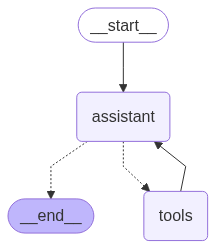

In [7]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode([tool]))


builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()


display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
messages = [HumanMessage(content="what do you know about efficient Training on Multiple CPUs using Intel chips in huggingface ?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what do you know about efficient Training on Multiple CPUs using Intel chips in huggingface ?
================================== Ai Message ==================================
Tool Calls:
  retriever_hugging_face_documentation (call_KI8YR28nBGQBgh79VWAYrU49)
 Call ID: call_KI8YR28nBGQBgh79VWAYrU49
  Args:
    query: Efficient Training on Multiple CPUs using Intel chips
================================= Tool Message =================================
Name: retriever_hugging_face_documentation

"\n\n# Efficient Training on Multiple CPUs\n\nWhen training on a single CPU is too slow, we can use multiple CPUs. This guide focuses on PyTorch-based DDP enabling distributed CPU training efficiently.\n\n## Intel\u00ae oneCCL Bindings for PyTorch\n\n[Intel\u00ae oneCCL](https://github.com/oneapi-src/oneCCL) (collective communications library) is a library for efficient distributed deep learning training implementing s